In [1]:
import os
import h5py
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,DepthwiseConv2D
from tensorflow.keras.layers import Activation,AveragePooling2D,Conv2D, RepeatVector, Permute, Multiply, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tcn import TCN
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.layers import LSTM

import numpy as np
import h5py
import glob # Used to find all file paths
import os

In [2]:
BASE_PATH_CROSS = 'Final Project data/Cross'
BASE_PATH_INTRA = 'Final Project data/Intra'

CROSS_TRAIN_DIR = os.path.join(BASE_PATH_CROSS, 'train/')
TEST1_DIR = os.path.join(BASE_PATH_CROSS, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH_CROSS, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH_CROSS, 'test3/')
INTRA_TRAIN_DIR = os.path.join(BASE_PATH_INTRA, 'train/')
INTRA_TEST_DIR = os.path.join(BASE_PATH_INTRA, 'test/')

# Constants
N_CHANNELS = 248
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
task_to_label = {task: i for i, task in enumerate(TASKS)}
DOWNSAMPLE_FACTOR = 10
WINDOW_SIZE = 250
STEP = 125

#loading and preprocessing funcs
def get_file_paths(directory):
    files = glob.glob(f"{directory}/*.h5")
    if not files:
        raise FileNotFoundError(f"No file found")
    return files

def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        task = None
        if 'rest' in filename:
            task = 'rest'
        elif 'motor' in filename:
            task = 'task_motor'
        elif 'story' in filename or 'math' in filename:
            task = 'task_story_math'
        elif 'working' in filename or 'memory' in filename:
            task = 'task_working_memory'

        if task:
            labels.append(task_to_label[task])
            with h5py.File(file_path, 'r') as f:
                dataset_name = list(f.keys())[0]
                matrix = f[dataset_name][()]
                data.append(matrix)
    return np.array(data), np.array(labels)

def windowing(data, labels, window_size, step):
    X_win, y_win = [], []
    for i in range(data.shape[0]):
        n_windows = (data.shape[2] - window_size) // step + 1
        for j in range(n_windows):
            start=j*step
            end = start +window_size
            X_win.append(data[i, :, start:end])
            y_win.append(labels[i])
    return np.array(X_win), np.array(y_win)

def normalize_data(data):
    """function for appluing time wise z-score normalization to each window"""
    n_samples, n_channels, n_timesteps = data.shape
    # reshape for scaler: (samples * channels, timesteps)
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)
    scaler = StandardScaler()

    scaled_data = scaler.fit_transform(reshaped_data)
    #reshap back to original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

def augment_data(data, labels, noise_factor=0.05, scale_factor_range=(0.9, 1.1)):
    """applies noises and scaling augmentation"""
    augmented_data, augmented_labels = [], []
    for i in range(len(data)):
        original_sample = data[i]
        original_label = labels[i]
        # add org sample
        augmented_data.append(original_sample)
        augmented_labels.append(original_label)
        # add augmented sample
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=original_sample.shape)
        scaler = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1])
        augmented_sample = (original_sample + noise) * scaler
        augmented_data.append(augmented_sample)
        augmented_labels.append(original_label)
    return np.array(augmented_data), np.array(augmented_labels)


# preproccessing
def preprocess_pipeline(base_dir, is_training=True, output_format='2d'):

    files = get_file_paths(base_dir)
    X, y = load_data(files)
    X_ds = X[:, :, ::DOWNSAMPLE_FACTOR]

    X_win, y_win = windowing(X_ds, y, WINDOW_SIZE, STEP)

    X_norm = normalize_data(X_win)

    if is_training:
        X_aug, y_aug = augment_data(X_norm, y_win)
        final_X, final_y = X_aug, y_aug
    else:
        final_X, final_y = X_norm, y_win

    if output_format == '2d':
        # Reshape for EEGNet/2D CNNs by adding a final dimension
        final_X = final_X[..., np.newaxis]
    elif output_format == '1d':
        # Reshape for Simple/1D CNNs by swapping the last two axes
        final_X = np.transpose(final_X, (0, 2, 1))
    else:
        raise ValueError("Invalid output_format")

    return final_X, final_y

X_train_1D, y_train_1D_final = preprocess_pipeline(CROSS_TRAIN_DIR, is_training=True, output_format='1d')
X_test1_1D, y_test1_1D_final = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='1d')
X_test2_1D, y_test2_1D_final = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='1d')
X_test3_1D, y_test3_1D_final = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='1d')

X_train_augmented = X_train_1D
y_train_augmented = y_train_1D_final
NUM_CLASSES = len(np.unique(y_train_1D_final))

INPUT_SHAPE = (X_train_1D.shape[1], X_train_1D.shape[2])

# CNN

In [3]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        
        Conv1D(filters=64, kernel_size=7, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=128, kernel_size=5, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        GlobalAveragePooling1D(),  # instead of Flatten to reduce overfitting

        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

simple_cnn = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)

simple_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

simple_cnn.summary()

# --- Training ---
simple_cnn.fit(
    X_train_1D,
    y_train_1D_final,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_simple_cnn, acc1_simple_cnn = simple_cnn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
loss2_simple_cnn, acc2_simple_cnn = simple_cnn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
loss3_simple_cnn, acc3_simple_cnn = simple_cnn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 250, 64)        │       111,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 125, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 62, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 62, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,020 (1.09 MB)

 Trainable params: 285,124 (1.09 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
87/87 - 3s - 38ms/step - accuracy: 0.9653 - loss: 0.0997 - val_accuracy: 0.9913 - val_loss: 0.0228
Epoch 2/20
87/87 - 2s - 26ms/step - accuracy: 0.9949 - loss: 0.0191 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/20
87/87 - 2s - 26ms/step - accuracy: 0.9964 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 8.5170e-05
Epoch 4/20
87/87 - 2s - 28ms/step - accuracy: 0.9957 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 2.5690e-04
Epoch 5/20
87/87 - 2s - 28ms/step - accuracy: 0.9960 - loss: 0.0149 - val_accuracy: 0.9913 - val_loss: 0.0442
Epoch 6/20
87/87 - 2s - 28ms/step - accuracy: 0.9989 - loss: 0.0053 - val_accuracy: 0.9971 - val_loss: 0.0046
Epoch 7/20
87/87 - 3s - 29ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 5.6710e-05
Epoch 8/20
87/87 - 2s - 29ms/step - accuracy: 0.9917 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 3.2022e-05
Epoch 9/20
87/87 - 2s - 29ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1

# LSTM

In [4]:
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Convolutional layers to extract features
        Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        Conv1D(filters=128, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        # LSTM layer to model temporal sequences of the extracted features
        LSTM(128, return_sequences=False), # return_sequences=False  it's the last recurrent layer

        # Dense layers for classification
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

cnn_lstm_model = build_cnn_lstm_model(INPUT_SHAPE, NUM_CLASSES)

cnn_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

# --- Training ---
cnn_lstm_model.fit(
    X_train_1D,
    y_train_1D_final,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_hybrid, acc1_hybrid = cnn_lstm_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
loss2_hybrid, acc2_hybrid = cnn_lstm_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
loss3_hybrid, acc3_hybrid = cnn_lstm_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

print(f"Average accuracy: {((acc1_hybrid + acc2_hybrid +acc3_hybrid)/3) * 100:.2f}%")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 250, 64)        │       158,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 250, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 62, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,212 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
87/87 - 4s - 44ms/step - accuracy: 0.9703 - loss: 0.1066 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 2/20
87/87 - 3s - 34ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 5.5175e-04
Epoch 3/20
87/87 - 3s - 32ms/step - accuracy: 1.0000 - loss: 5.5230e-04 - val_accuracy: 1.0000 - val_loss: 2.2135e-04
Epoch 4/20
87/87 - 3s - 34ms/step - accuracy: 1.0000 - loss: 4.3498e-04 - val_accuracy: 1.0000 - val_loss: 1.1749e-04
Epoch 5/20
87/87 - 3s - 32ms/step - accuracy: 1.0000 - loss: 1.9921e-04 - val_accuracy: 1.0000 - val_loss: 3.8049e-05
Epoch 6/20
87/87 - 3s - 33ms/step - accuracy: 1.0000 - loss: 2.7842e-04 - val_accuracy: 1.0000 - val_loss: 1.0850e-05
Epoch 7/20
87/87 - 3s - 33ms/step - accuracy: 1.0000 - loss: 1.2083e-04 - val_accuracy: 1.0000 - val_loss: 4.8640e-06
Epoch 8/20
87/87 - 3s - 33ms/step - accuracy: 0.9877 - loss: 0.0488 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 9/20
87/87 - 3s - 32ms/step - accuracy: 1.0000 - loss: 6.7060e-04 - va

# TCN

In [5]:
def build_tcn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8, 16], return_sequences=False),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

build_tcn_model_model = build_tcn_model(INPUT_SHAPE, NUM_CLASSES)

build_tcn_model_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

build_tcn_model_model.summary()

# --- Training ---
build_tcn_model_model.fit(
    X_train_1D,
    y_train_1D_final,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    verbose=2
)



# Evaluate on test sets
loss1_build_tcn_model, acc1_build_tcn_model = build_tcn_model_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_build_tcn_model * 100:.2f}%")
loss2_build_tcn_model, acc2_build_tcn_model = build_tcn_model_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_build_tcn_model * 100:.2f}%")
loss3_build_tcn_model, acc3_build_tcn_model = build_tcn_model_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_build_tcn_model * 100:.2f}%")

print(f"Average accuracy: {((acc1_build_tcn_model + acc2_build_tcn_model +acc3_build_tcn_model)/3) * 100:.2f}%")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,516 (1.07 MB)

 Trainable params: 280,516 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
87/87 - 32s - 373ms/step - accuracy: 0.8828 - loss: 1.2317 - val_accuracy: 1.0000 - val_loss: 1.3075e-04
Epoch 2/20
87/87 - 12s - 136ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 2.2032e-05
Epoch 3/20
87/87 - 27s - 311ms/step - accuracy: 1.0000 - loss: 7.0413e-04 - val_accuracy: 1.0000 - val_loss: 7.6693e-06
Epoch 4/20
87/87 - 25s - 288ms/step - accuracy: 0.9996 - loss: 7.0781e-04 - val_accuracy: 1.0000 - val_loss: 2.8746e-06
Epoch 5/20
87/87 - 10s - 120ms/step - accuracy: 1.0000 - loss: 1.1766e-04 - val_accuracy: 1.0000 - val_loss: 1.4651e-06
Epoch 6/20
87/87 - 10s - 112ms/step - accuracy: 1.0000 - loss: 1.2723e-04 - val_accuracy: 1.0000 - val_loss: 7.5504e-07
Epoch 7/20
87/87 - 5s - 60ms/step - accuracy: 1.0000 - loss: 1.4518e-04 - val_accuracy: 1.0000 - val_loss: 4.4703e-07
Epoch 8/20
87/87 - 5s - 57ms/step - accuracy: 1.0000 - loss: 5.5465e-05 - val_accuracy: 1.0000 - val_loss: 3.6073e-07
Epoch 9/20
87/87 - 5s - 55ms/step - accuracy: 0.9761

# Optimization

In [6]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def make_optimized_objective(build_model_fn, max_epochs=10, batch_size=32):
    best_model_container = {"model": None, "best_acc": 0.0}

    def objective(trial):
        window_size = trial.suggest_int("window_size", 100, 400, step=50)
        step_size = trial.suggest_int("step_size", 25, 300, step=25)

        # Re-run preprocessing with new window and step sizes
        global WINDOW_SIZE, STEP
        WINDOW_SIZE = window_size
        STEP = step_size

        X_train, y_train = preprocess_pipeline(CROSS_TRAIN_DIR, is_training=True, output_format='1d')
        X_test1, y_test1 = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='1d')
        X_test2, y_test2 = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='1d')
        X_test3, y_test3 = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='1d')

        # Validate shape
        if X_train.shape[1] != window_size:
            return 0.0

        num_classes = len(np.unique(y_train))
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_model_fn(input_shape, num_classes)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42)

        model.fit(
            X_train_sub, y_train_sub,
            validation_data=(X_val_sub, y_val_sub),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
        )

        _, acc1 = model.evaluate(X_test1, y_test1, verbose=0)
        _, acc2 = model.evaluate(X_test2, y_test2, verbose=0)
        _, acc3 = model.evaluate(X_test3, y_test3, verbose=0)
        avg_acc = (acc1 + acc2 + acc3) / 3

        if avg_acc > best_model_container["best_acc"]:
            best_model_container["model"] = model
            best_model_container["best_acc"] = avg_acc

        return avg_acc

    return objective, best_model_container




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
objective, best_model_container_cnn = make_optimized_objective(build_cnn_model)
study_cnn = optuna.create_study(direction='maximize')
study_cnn.optimize(objective, n_trials=20)

best_model_cnn = best_model_container_cnn["model"]
print("Best average accuracy:", best_model_container_cnn["best_acc"])
print("Best parameters:", study_cnn.best_params)

[I 2025-06-17 09:00:14,688] A new study created in memory with name: no-name-2dd0d52e-ad44-4851-b982-845f28c52508
[I 2025-06-17 09:01:04,298] Trial 0 finished with value: 0.6775568127632141 and parameters: {'window_size': 300, 'step_size': 75}. Best is trial 0 with value: 0.6775568127632141.
[I 2025-06-17 09:02:52,621] Trial 1 finished with value: 0.6644230683644613 and parameters: {'window_size': 350, 'step_size': 50}. Best is trial 0 with value: 0.6775568127632141.
[I 2025-06-17 09:03:20,543] Trial 2 finished with value: 0.6770833333333334 and parameters: {'window_size': 400, 'step_size': 200}. Best is trial 0 with value: 0.6775568127632141.
[I 2025-06-17 09:03:38,911] Trial 3 finished with value: 0.7327380875746409 and parameters: {'window_size': 100, 'step_size': 50}. Best is trial 3 with value: 0.7327380875746409.
[I 2025-06-17 09:03:54,955] Trial 4 finished with value: 0.6875 and parameters: {'window_size': 250, 'step_size': 250}. Best is trial 3 with value: 0.7327380875746409.
[

Best average accuracy: 0.745192309220632
Best parameters: {'window_size': 350, 'step_size': 125}


In [8]:
objective_lstm, best_model_container_lstm = make_optimized_objective(build_cnn_lstm_model)
study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(objective_lstm, n_trials=20)

best_model_lstm = best_model_container_lstm["model"]
print("Best average accuracy:", best_model_container_lstm["best_acc"])
print("Best parameters:", study_lstm.best_params)

[I 2025-06-17 09:09:28,481] A new study created in memory with name: no-name-e14e15e6-0707-4477-a638-9bb438c6df73
[I 2025-06-17 09:17:03,515] Trial 0 finished with value: 0.669291357199351 and parameters: {'window_size': 400, 'step_size': 25}. Best is trial 0 with value: 0.669291357199351.
[I 2025-06-17 09:22:20,523] Trial 1 finished with value: 0.7293281654516856 and parameters: {'window_size': 350, 'step_size': 25}. Best is trial 1 with value: 0.7293281654516856.
[I 2025-06-17 09:22:34,397] Trial 2 finished with value: 0.6919642786184946 and parameters: {'window_size': 300, 'step_size': 250}. Best is trial 1 with value: 0.7293281654516856.
[I 2025-06-17 09:24:15,918] Trial 3 finished with value: 0.6793619791666666 and parameters: {'window_size': 400, 'step_size': 50}. Best is trial 1 with value: 0.7293281654516856.
[I 2025-06-17 09:24:26,274] Trial 4 finished with value: 0.7440476218859354 and parameters: {'window_size': 100, 'step_size': 125}. Best is trial 4 with value: 0.744047621

Best average accuracy: 0.7440476218859354
Best parameters: {'window_size': 100, 'step_size': 125}


In [11]:
objective_tcn, best_model_container_tcn = make_optimized_objective(build_tcn_model)
study_tcn = optuna.create_study(direction='maximize')
study_tcn.optimize(objective, n_trials=20)

best_model_tcn = best_model_container_tcn["model"]
print("Best average accuracy:", best_model_container_tcn["best_acc"])
print("Best parameters:", study_tcn.best_params)

[I 2025-06-17 09:50:09,403] A new study created in memory with name: no-name-68f12221-2715-489e-85eb-23d7dab1a2b5
[I 2025-06-17 09:50:23,640] Trial 0 finished with value: 0.6857638855775198 and parameters: {'window_size': 200, 'step_size': 300}. Best is trial 0 with value: 0.6857638855775198.
[I 2025-06-17 09:50:37,705] Trial 1 finished with value: 0.7242647210756937 and parameters: {'window_size': 200, 'step_size': 200}. Best is trial 1 with value: 0.7242647210756937.
[I 2025-06-17 09:50:56,832] Trial 2 finished with value: 0.6875 and parameters: {'window_size': 300, 'step_size': 250}. Best is trial 1 with value: 0.7242647210756937.
[I 2025-06-17 09:55:51,570] Trial 3 finished with value: 0.6789122223854065 and parameters: {'window_size': 300, 'step_size': 25}. Best is trial 1 with value: 0.7242647210756937.
[I 2025-06-17 09:56:23,230] Trial 4 finished with value: 0.7488095263640085 and parameters: {'window_size': 100, 'step_size': 50}. Best is trial 4 with value: 0.7488095263640085.


Best average accuracy: 0.0
Best parameters: {'window_size': 100, 'step_size': 50}


In [13]:
# Evaluate on test sets for CNN
loss1_simple_cnn, acc1_simple_cnn = best_model_cnn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
loss2_simple_cnn, acc2_simple_cnn = best_model_cnn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
loss3_simple_cnn, acc3_simple_cnn = best_model_cnn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")


# Evaluate on test sets for LSTM
loss1_hybrid, acc1_hybrid = best_model_lstm.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
loss2_hybrid, acc2_hybrid = best_model_lstm.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
loss3_hybrid, acc3_hybrid = best_model_lstm.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

print(f"Average accuracy: {((acc1_hybrid + acc2_hybrid +acc3_hybrid)/3) * 100:.2f}%")



# Evaluate on test sets for TCN
loss1_build_tcn_model, acc1_build_tcn_model = best_model_tcn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_build_tcn_model * 100:.2f}%")
loss2_build_tcn_model, acc2_build_tcn_model = best_model_tcn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_build_tcn_model * 100:.2f}%")
loss3_build_tcn_model, acc3_build_tcn_model = best_model_tcn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_build_tcn_model * 100:.2f}%")

print(f"Average accuracy: {((acc1_build_tcn_model + acc2_build_tcn_model +acc3_build_tcn_model)/3) * 100:.2f}%")

simple_cnn Model Accuracy on Test Set 1: 96.06%
simple_cnn Model Accuracy on Test Set 2: 45.14%
simple_cnn Model Accuracy on Test Set 3: 82.41%
Average accuracy: 74.54%
Hybrid Model Accuracy on Test Set 1: 97.69%
Hybrid Model Accuracy on Test Set 2: 45.14%
Hybrid Model Accuracy on Test Set 3: 81.02%
Average accuracy: 74.61%


AttributeError: 'NoneType' object has no attribute 'evaluate'

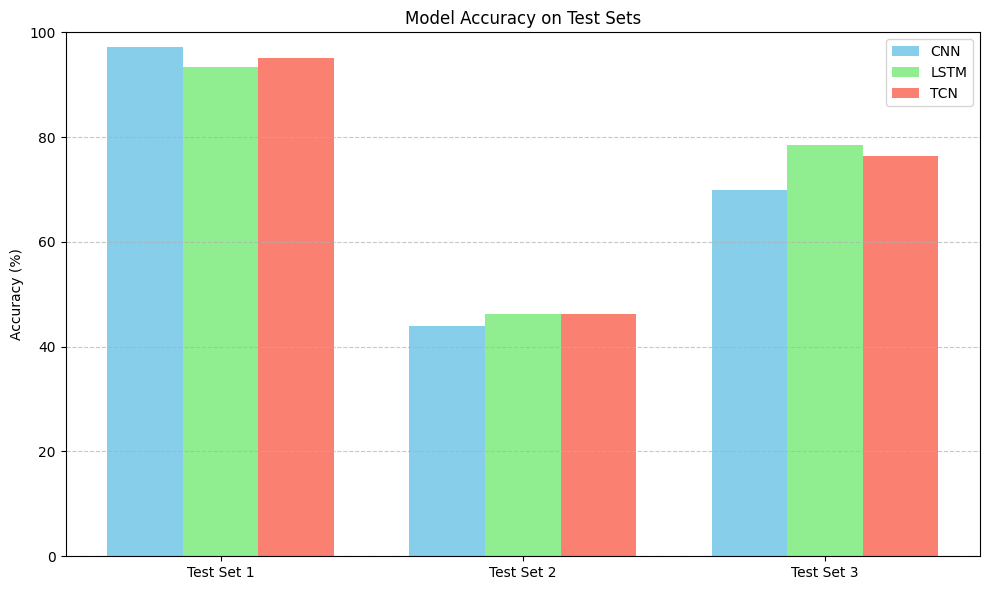

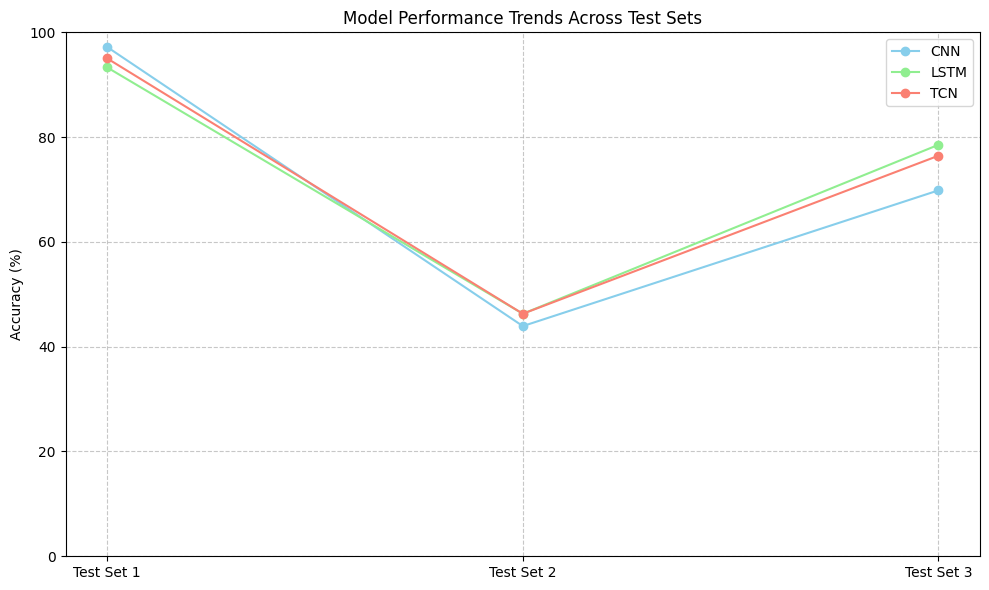

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracies (convert to percentages for plotting)
cnn_accs = [acc1_simple_cnn * 100, acc2_simple_cnn * 100, acc3_simple_cnn * 100]
lstm_accs = [acc1_hybrid * 100, acc2_hybrid * 100, acc3_hybrid * 100]
tcn_accs = [acc1_build_tcn_model * 100, acc2_build_tcn_model * 100, acc3_build_tcn_model * 100]

test_sets = ['Test Set 1', 'Test Set 2', 'Test Set 3']
x = np.arange(len(test_sets))
width = 0.25  # bar width

# === Grouped Bar Plot ===
plt.figure(figsize=(10, 6))
plt.bar(x - width, cnn_accs, width, label='CNN', color='skyblue')
plt.bar(x, lstm_accs, width, label='LSTM', color='lightgreen')
plt.bar(x + width, tcn_accs, width, label='TCN', color='salmon')

plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Test Sets')
plt.xticks(x, test_sets)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Line Plot for Model Trends ===
plt.figure(figsize=(10, 6))
plt.plot(test_sets, cnn_accs, marker='o', label='CNN', color='skyblue')
plt.plot(test_sets, lstm_accs, marker='o', label='LSTM', color='lightgreen')
plt.plot(test_sets, tcn_accs, marker='o', label='TCN', color='salmon')

plt.ylabel('Accuracy (%)')
plt.title('Model Performance Trends Across Test Sets')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


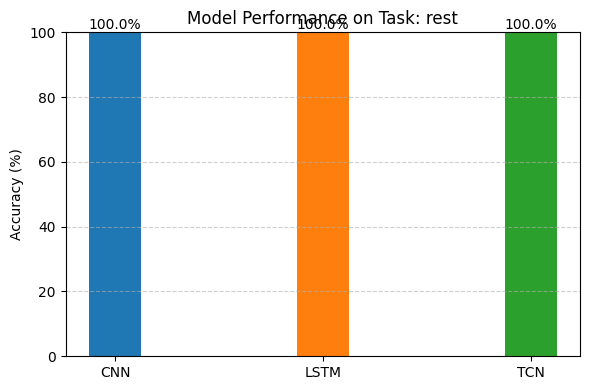

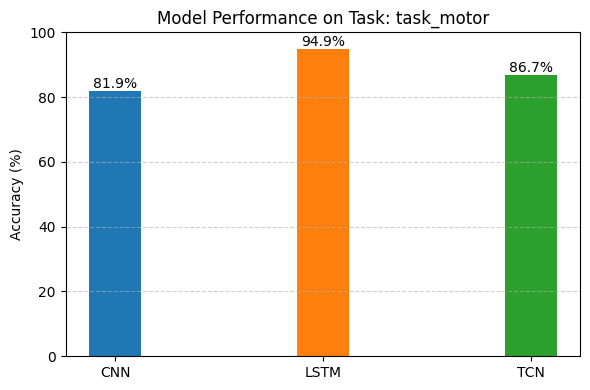

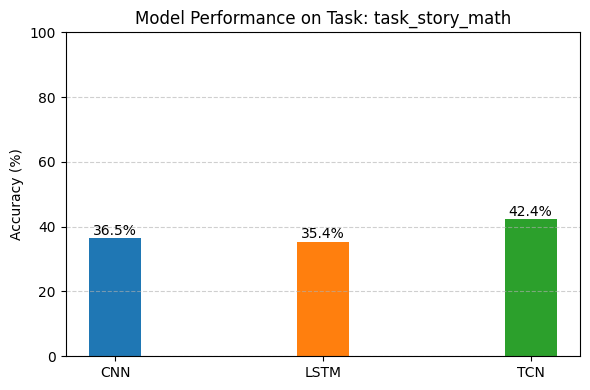

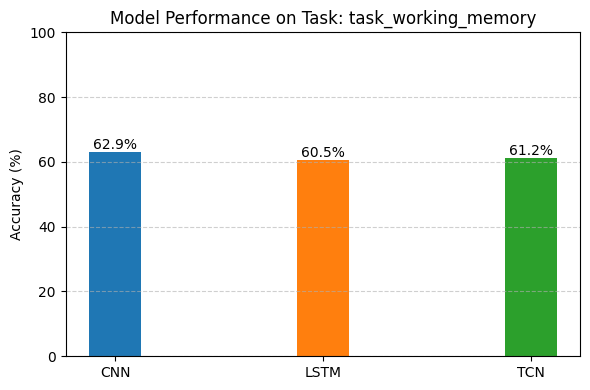

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# List of test sets and labels
X_tests = [X_test1_1D, X_test2_1D, X_test3_1D]
y_tests = [y_test1_1D_final, y_test2_1D_final, y_test3_1D_final]
task_names = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']

# Store model predictions
model_preds = {
    "CNN": [],
    "LSTM": [],
    "TCN": []
}

# Store ground truths
all_y_true = []

# Collect predictions from all models
for X, y_true in zip(X_tests, y_tests):
    model_preds["CNN"].append(np.argmax(best_model_cnn.predict(X, verbose=0), axis=1))
    model_preds["LSTM"].append(np.argmax(best_model_lstm.predict(X, verbose=0), axis=1))
    model_preds["TCN"].append(np.argmax(best_model_tcn.predict(X, verbose=0), axis=1))
    all_y_true.append(y_true)

# Combine across all test sets
y_true_all = np.concatenate(all_y_true)
preds_all = {
    name: np.concatenate(pred_list) for name, pred_list in model_preds.items()
}

# Calculate per-task accuracy
task_performance = {name: [] for name in model_preds}

for label in range(4):  # for each task
    indices = np.where(y_true_all == label)[0]
    for model_name in preds_all:
        acc = accuracy_score(y_true_all[indices], preds_all[model_name][indices])
        task_performance[model_name].append(acc * 100)  # convert to %

# Plot
x = np.arange(len(model_preds))  # 3 models
width = 0.25

for i, task in enumerate(task_names):
    plt.figure(figsize=(6, 4))
    scores = [task_performance[model][i] for model in model_preds]
    plt.bar(x, scores, width, tick_label=list(model_preds.keys()), color=["#1f77b4", "#ff7f0e", "#2ca02c"])
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.title(f"Model Performance on Task: {task}")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    for j, score in enumerate(scores):
        plt.text(j, score + 1, f"{score:.1f}%", ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()


In [ ]:
# best_model_cnn.save('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/cnn_model.keras')  # Folder will be created if it doesn't exist
# best_model_lstm.save('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/lstm_model.keras')  # Folder will be created if it doesn't exist
# best_model_tcn.save('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/tcn_model.keras')  # Folder will be created if it doesn't exist


In [ ]:
from tensorflow.keras.models import load_model
cnn_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/cnn_model.keras')
lstm_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/lstm_model.keras')
tcn_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/tcn_model.keras')
eeg_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/eegnet_cross.h5')

In [ ]:



# Evaluate on test sets for CNN
loss1_simple_cnn, acc1_simple_cnn = cnn_load_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
loss2_simple_cnn, acc2_simple_cnn = cnn_load_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
loss3_simple_cnn, acc3_simple_cnn = cnn_load_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")


# Evaluate on test sets for LSTM
loss1_hybrid, acc1_hybrid = lstm_load_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
loss2_hybrid, acc2_hybrid = lstm_load_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
loss3_hybrid, acc3_hybrid = lstm_load_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

print(f"Average accuracy: {((acc1_hybrid + acc2_hybrid +acc3_hybrid)/3) * 100:.2f}%")



# Evaluate on test sets for TCN
loss1_build_tcn_model, acc1_build_tcn_model = tcn_load_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 1: {acc1_build_tcn_model * 100:.2f}%")
loss2_build_tcn_model, acc2_build_tcn_model = tcn_load_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 2: {acc2_build_tcn_model * 100:.2f}%")
loss3_build_tcn_model, acc3_build_tcn_model = tcn_load_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
print(f"temporal attention Model Accuracy on Test Set 3: {acc3_build_tcn_model * 100:.2f}%")

print(f"Average accuracy: {((acc1_build_tcn_model + acc2_build_tcn_model +acc3_build_tcn_model)/3) * 100:.2f}%")



X_test1_reshaped = np.transpose(X_test1_1D, (0, 2, 1))[..., np.newaxis]  # (N, 248, 150, 1)
X_test2_reshaped = np.transpose(X_test2_1D, (0, 2, 1))[..., np.newaxis]
X_test3_reshaped = np.transpose(X_test3_1D, (0, 2, 1))[..., np.newaxis]
y_test1_load_final = to_categorical(y_test1_1D_final, num_classes=4)
y_test2_load_final = to_categorical(y_test2_1D_final, num_classes=4)
y_test3_load_final = to_categorical(y_test3_1D_final, num_classes=4)

# Evaluate on test sets for TCN
loss1_eeg, acc1_eeg = eeg_load_model.evaluate(X_test1_reshaped, y_test1_load_final, verbose=0)
print(f"Model Accuracy on Test Set 1: {acc1_eeg * 100:.2f}%")

loss2_eeg, acc2_eeg = eeg_load_model.evaluate(X_test2_reshaped, y_test2_load_final, verbose=0)
print(f"Model Accuracy on Test Set 2: {acc2_eeg * 100:.2f}%")

loss3_eeg, acc3_eeg = eeg_load_model.evaluate(X_test3_reshaped, y_test3_load_final, verbose=0)
print(f"Model Accuracy on Test Set 3: {acc3_eeg * 100:.2f}%")

print(f"Average accuracy: {((acc1_eeg + acc2_eeg + acc3_eeg) / 3) * 100:.2f}%")


simple_cnn Model Accuracy on Test Set 1: 97.55%
simple_cnn Model Accuracy on Test Set 2: 43.39%
simple_cnn Model Accuracy on Test Set 3: 76.00%
Average accuracy: 72.31%
Hybrid Model Accuracy on Test Set 1: 98.10%
Hybrid Model Accuracy on Test Set 2: 43.48%
Hybrid Model Accuracy on Test Set 3: 77.81%
Average accuracy: 73.13%
temporal attention Model Accuracy on Test Set 1: 93.66%
temporal attention Model Accuracy on Test Set 2: 66.94%
temporal attention Model Accuracy on Test Set 3: 66.94%
Average accuracy: 75.85%
Model Accuracy on Test Set 1: 98.91%
Model Accuracy on Test Set 2: 40.40%
Model Accuracy on Test Set 3: 90.94%
Average accuracy: 76.75%


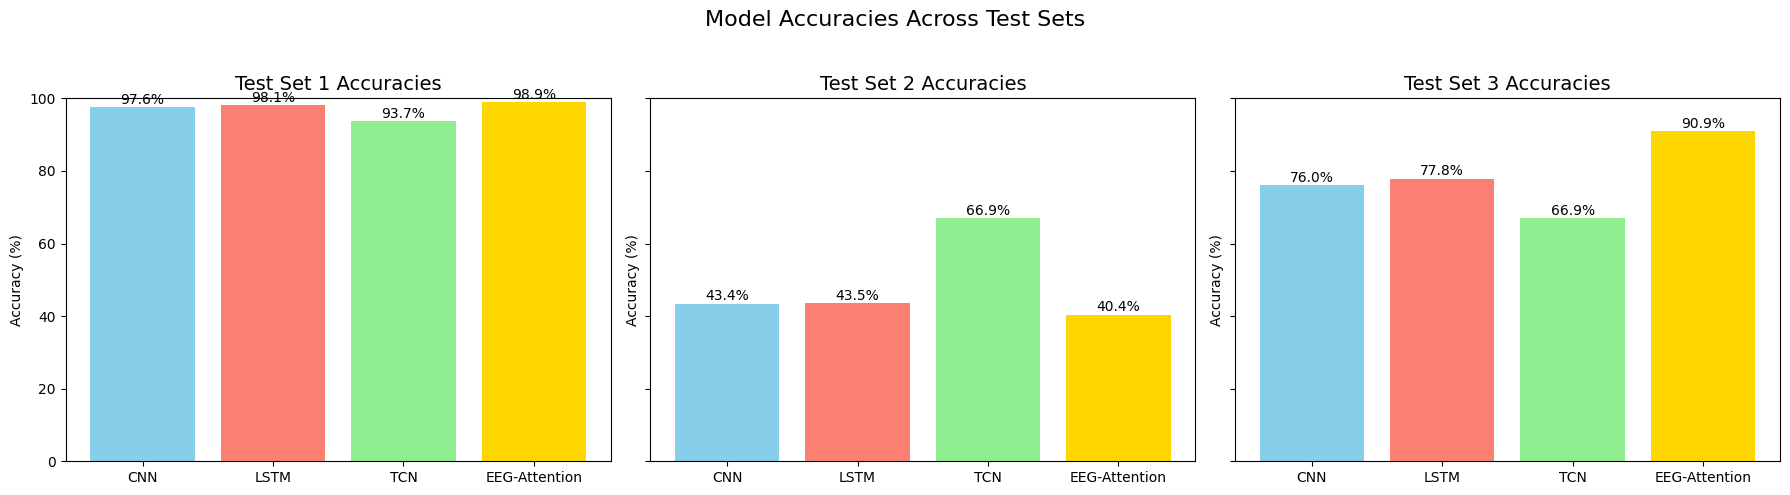

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracies
test_set_1 = [acc1_simple_cnn, acc1_hybrid, acc1_build_tcn_model, acc1_eeg]
test_set_2 = [acc2_simple_cnn, acc2_hybrid, acc2_build_tcn_model, acc2_eeg]
test_set_3 = [acc3_simple_cnn, acc3_hybrid, acc3_build_tcn_model, acc3_eeg]

# Model names
model_names = ['CNN', 'LSTM', 'TCN', 'EEG-Attention']

# Colors for each model
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']

# Plot setup
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
test_sets = [test_set_1, test_set_2, test_set_3]

for i, ax in enumerate(axs):
    ax.bar(model_names, [acc * 100 for acc in test_sets[i]], color=colors)
    ax.set_title(f'Test Set {i+1} Accuracies', fontsize=14)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(0, 100)
    for j, acc in enumerate(test_sets[i]):
        ax.text(j, acc * 100 + 1, f'{acc*100:.1f}%', ha='center', fontsize=10)

plt.suptitle('Model Accuracies Across Test Sets', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


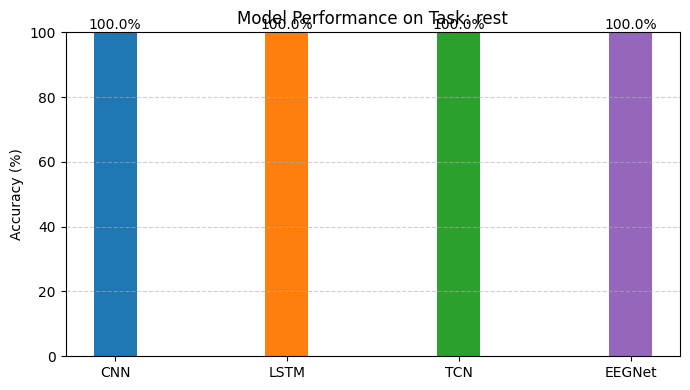

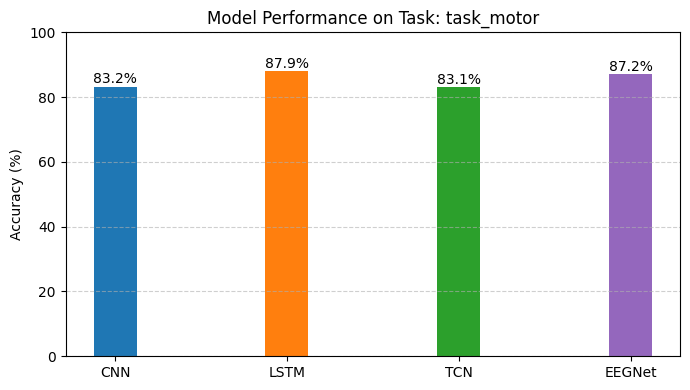

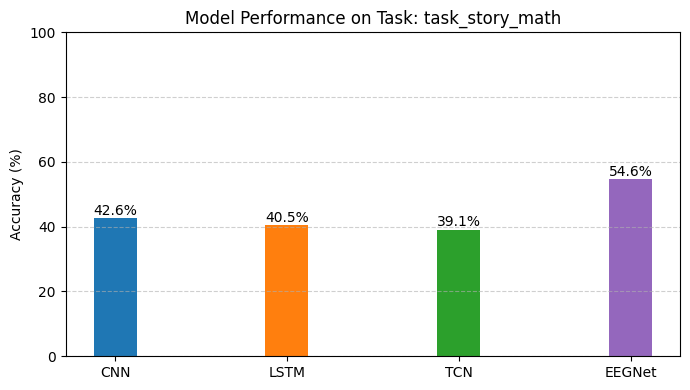

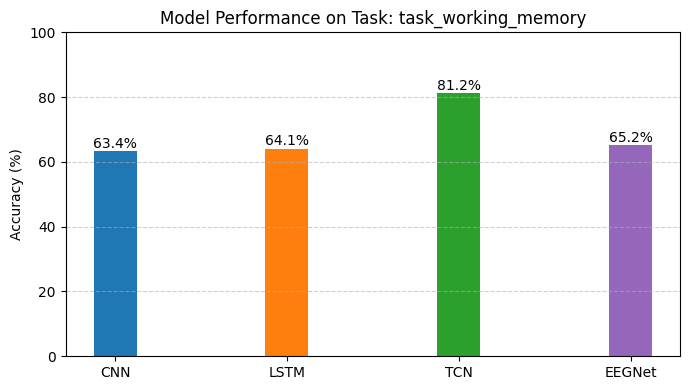

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Test sets and labels
X_tests = [X_test1_1D, X_test2_1D, X_test3_1D]
y_tests = [y_test1_1D_final, y_test2_1D_final, y_test3_1D_final]
task_names = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']

# Store model predictions
model_preds = {
    "CNN": [],
    "LSTM": [],
    "TCN": [],
    "EEGNet": []
}

# Store ground truths
all_y_true = []

# Collect predictions from all models
for i, (X, y_true) in enumerate(zip(X_tests, y_tests)):
    # Append predictions for CNN, LSTM, TCN
    model_preds["CNN"].append(np.argmax(cnn_load_model.predict(X, verbose=0), axis=1))
    model_preds["LSTM"].append(np.argmax(lstm_load_model.predict(X, verbose=0), axis=1))
    model_preds["TCN"].append(np.argmax(tcn_load_model.predict(X, verbose=0), axis=1))
    
    # EEGNet requires reshaped input: (N, channels, time, 1)
    X_eeg = np.transpose(X, (0, 2, 1))[..., np.newaxis]
    model_preds["EEGNet"].append(np.argmax(eeg_load_model.predict(X_eeg, verbose=0), axis=1))
    
    all_y_true.append(y_true)

# Combine across all test sets
y_true_all = np.concatenate(all_y_true)
preds_all = {name: np.concatenate(pred_list) for name, pred_list in model_preds.items()}

# Calculate per-task accuracy
task_performance = {name: [] for name in model_preds}

for label in range(4):  # 4 tasks
    indices = np.where(y_true_all == label)[0]
    for model_name in preds_all:
        acc = accuracy_score(y_true_all[indices], preds_all[model_name][indices])
        task_performance[model_name].append(acc * 100)

# Plotting
x = np.arange(len(model_preds))  # 4 models now
width = 0.25

for i, task in enumerate(task_names):
    plt.figure(figsize=(7, 4))
    scores = [task_performance[model][i] for model in model_preds]
    plt.bar(x, scores, width, tick_label=list(model_preds.keys()), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"])
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.title(f"Model Performance on Task: {task}")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    for j, score in enumerate(scores):
        plt.text(j, score + 1, f"{score:.1f}%", ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()


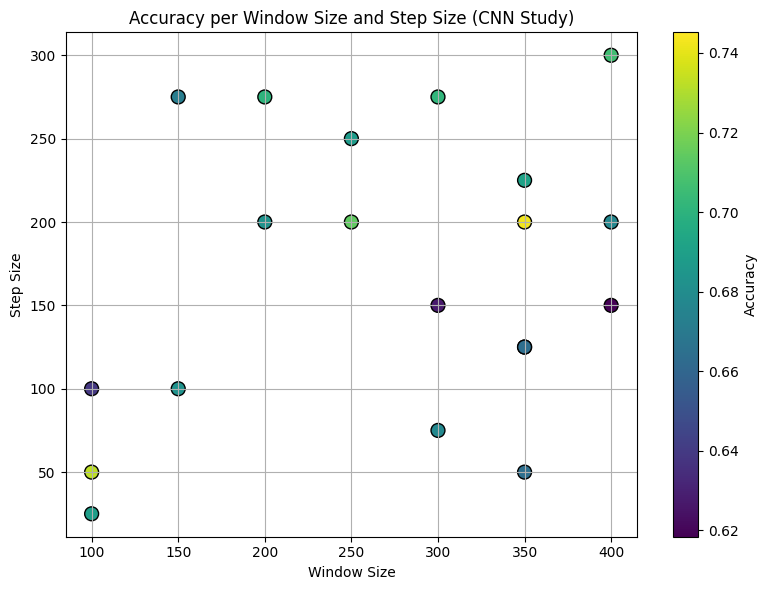

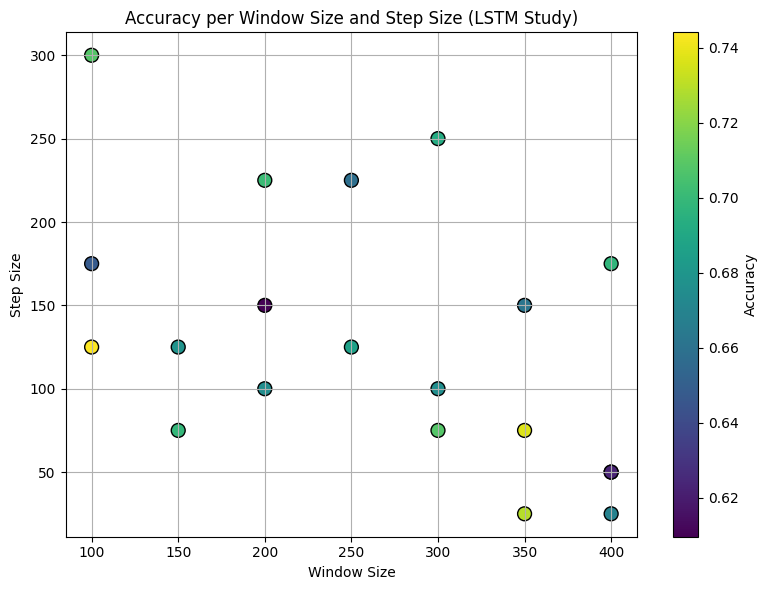

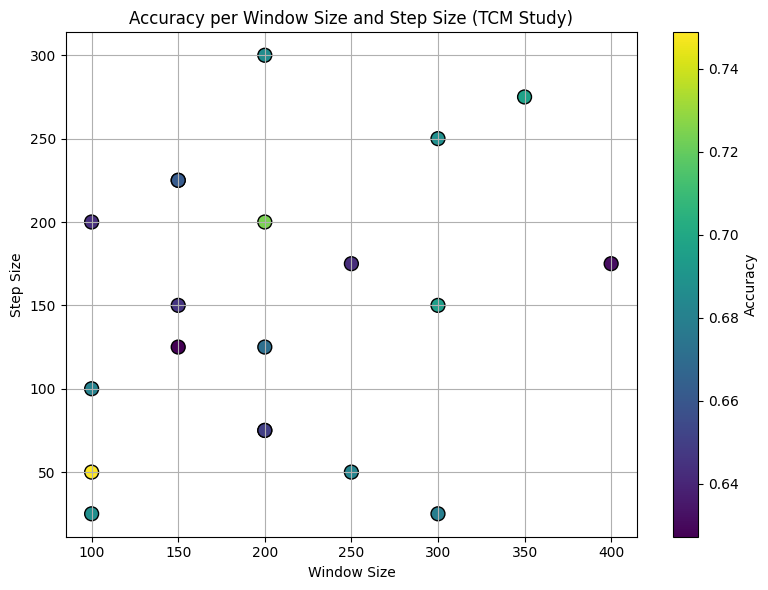

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# List of studies and corresponding titles
studies = [study_cnn, study_lstm, study_tcn]
titles = ['CNN Study', 'LSTM Study', 'TCM Study']

for study, title in zip(studies, titles):
    window_sizes = []
    step_sizes = []
    accuracies = []

    for trial in study.trials:
        if trial.value is not None and "window_size" in trial.params and "step_size" in trial.params:
            window_sizes.append(trial.params["window_size"])
            step_sizes.append(trial.params["step_size"])
            accuracies.append(trial.value)

    if not accuracies:
        print(f"No valid trials for {title}. Skipping plot.")
        continue

    window_sizes = np.array(window_sizes)
    step_sizes = np.array(step_sizes)
    accuracies = np.array(accuracies)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(window_sizes, step_sizes, c=accuracies, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(scatter, label='Accuracy')
    plt.xlabel('Window Size')
    plt.ylabel('Step Size')
    plt.title(f'Accuracy per Window Size and Step Size ({title})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
